In [105]:
class varDataset:

    r"""
    Creates an instance of dataset object based on requested files & variable.

    Parameters
    ----------
    path : str
        Directory containing files for concatenation.
    varname : str
        Name of variable in files.
    climo : ndarray


    Other Parameters
    ----------------
    level : float
        If file contains data for multiple levels
    climoyears : tuple
        (start year, end year) to slice data
    latbounds : tuple
        (south lat, north lat) to slice data
    lonbounds : tuple)
        (west lon, east lon) to slice data
    eofs : ndarray
        Provided eofs
    max_eofs : int
        How many modes to retain from the EOF decomposition.
    time_window : int
        Used for running_mean, days.

    Returns
    -------
    Dataset : object
        An instance of Dataset.
    """

    def __init__(self,varlabel,datapath,varname,**kwargs):

        self.varlabel = varlabel
        self.datapath = datapath
        self.varname = varname
        # kwargs
        self.level = kwargs.pop('level',None)
        self.climoyears = kwargs.pop('climoyears',None)
        self.datebounds = kwargs.pop('datebounds',('1/1','12/31'))
        season0 = kwargs.pop('season0',True)
        self.latbounds = kwargs.pop('latbounds',None)
        self.lonbounds = kwargs.pop('lonbounds',None)
        self.time_window = kwargs.pop('time_window',None)
        self.climo = kwargs.pop('climo',None)
        self.landmask = kwargs.pop('landmask',False)
        self.smoother = kwargs.pop('smoother',None)
        self.coarsegrain = kwargs.pop('coarsegrain',None)
        self.attrs = {}

        # Concatenate all files into one dataset
        filenames = sorted([join(datapath, f) for f in listdir(datapath) \
                     if isfile(join(datapath, f)) and f.endswith('.nc')])

        ds = self.get_ds(filenames)
        if self.climoyears is None:
            self.climoyears = (min(ds['time']).year,max(ds['time']).year)
        climo_set = np.array([(i.year>=min(self.climoyears)) & (i.year<=max(self.climoyears)) for i in ds['time']])
        print(self.climoyears)
        # print(ds['time'])
        # print(climo_set)
        ds['time'] = ds['time'][climo_set]
        ds['var'] = ds['var'][climo_set]

        self.lat = ds['lat'][self.domain]
        self.lon = ds['lon'][self.domain]
        self.latgrid = ds['lat']
        self.longrid = ds['lon']

        # Data manipulation
        if self.climo is None:
            print('getting climo, Line 119 dataset')
            self.climo = get_climo(ds['var'],ds['time'],self.climoyears)
        else:
            self.climo = np.array([self.flatten(i) for i in self.climo])
            self.climo[abs(self.climo)>1e29]=np.nan

        if self.varname == 'anomaly':
            anomaly = copy.copy(ds['var'])
        else:
            print('getting anomaly, Line 127 dataset')
            anomaly = get_anomaly(ds['var'],ds['time'],self.climo)

        if self.time_window is None:
            self.running_mean = anomaly
        else:
            self.running_mean = get_running_mean(anomaly,self.time_window)[self.time_window:]
            ds['time'] = ds['time'][self.time_window:]

        if season0:
            datewhere = np.where(list(map(self._date_range_test,ds['time'])) & \
                                 (ds['time']>=dt.strptime(f'{min(self.climoyears)}/{self.datebounds[0]}','%Y/%m/%d')) & \
                                 (ds['time']<=dt.strptime(f'{max(self.climoyears)}/{self.datebounds[1]}','%Y/%m/%d')))[0]
        else:
            datewhere = np.where(list(map(self._date_range_test,ds['time'])))[0]

        self.time = ds['time'][datewhere]
        if isinstance(self.time,np.ma.MaskedArray):
            self.time = self.time.data
        self.running_mean = self.running_mean[datewhere]

        self.climo_stdev = np.nanstd(self.running_mean)
        self.climo_mean = np.nanmean(self.running_mean)


    def get_ds(self,filenames):

        ds = {}
        print('--> Starting to gather data')
        timer_start = dt.now()
        for prog,fname in enumerate(filenames):
            print(f'getting {fname}')
            ds0 = nc.Dataset(fname)
            # print(ds0['time'])

            if 'climo' in ds0.variables:
                self.climo = ds0['climo']

            lat_name = ([s for s in ds0.variables.keys() if 'lat' in s]+[None])[0]
            lon_name = ([s for s in ds0.variables.keys() if 'lon' in s]+[None])[0]
            lev_name = ([s for s in ds0.variables.keys() if 'lev' in s or 'lv_' in s]+[None])[0]
            time_name = ([s for s in ds0.variables.keys() if 'time' in s]+[None])[0]
            var_name = self.varname

            try:
                self.attrs['long_name']=ds0[var_name].long_name
            except:
                self.attrs['long_name']=None
            try:
                self.attrs['units']=ds0[var_name].units
            except:
                self.attrs['units']=None

            ds['lat']=ds0[lat_name][:]
            ds['lon']=ds0[lon_name][:]%360
            if len(ds['lat'].shape)==1:
                ds['lon'],ds['lat'] = np.meshgrid(ds['lon'],ds['lat'])
            if lev_name is not None:
                if self.level is None:
                    ilev = 0
                else:
                    ilev = list(ds0[lev_name]).index(self.level)
                    self.attrs['level']=self.level
                ds['lev']=ds0[lev_name][:][ilev]
            try:
                timeunits = ds0[time_name].Units
            except:
                timeunits = ds0[time_name].units
            if timeunits=='Daily':
                yr = int(fname[-7:-3])
                tmp = np.array([dt(yr,1,1)+timedelta(days=i-1) for i in ds0[time_name][:]])
            else:
                tmp = nc.num2date(ds0[time_name][:],timeunits,\
                                  only_use_cftime_datetimes=False,only_use_python_datetimes=True)
                # print(tmp)
            perday = int(86400/(tmp[1]-tmp[0]).total_seconds())
            # print(perday)
            tmp = tmp[::perday]

            if prog==0:
                ds['time'] = tmp
            else:
                ds['time'] = np.append(ds['time'],tmp)

            if len(ds0[var_name].shape)>3:
                newdata = ds0[var_name][:,ilev].squeeze()
            elif len(ds0[var_name].shape)<3:
                newdata = ds0[var_name][None,:]
            else:
                newdata = ds0[var_name][:]

            if perday != 1:
                newdata = np.apply_along_axis(lambda x: np.convolve(x,np.ones(perday)/perday, mode='valid')[::4],\
                                              axis=0, arr=newdata)

            if self.smoother is not None:
                newdata = gfilt(newdata,[0]+[self.smoother]*len(newdata.shape[1:]))

            if self.coarsegrain is not None:
                lonres = abs(statistics.mode(np.gradient(ds['lon'].data)[1].flatten()))
                latres = abs(statistics.mode(np.gradient(ds['lat'].data)[0].flatten()))
                lonbin = int(self.coarsegrain/lonres)
                latbin = int(self.coarsegrain/latres)
                new_lats = ds['lat'][::latbin,::lonbin]
                new_lons = ds['lon'][::latbin,::lonbin]
                newdata = newdata[:,::latbin,::lonbin]
                ds['lat']=new_lats
                ds['lon']=new_lons

            self.mapgrid = np.ones(newdata.shape[1:])*np.nan

            if self.latbounds is None:
                lim_S = np.amin(ds['lat'])
                lim_N = np.amax(ds['lat'])
            else:
                lim_S = min(self.latbounds)
                lim_N = max(self.latbounds)
            if self.lonbounds is None:
                lim_W = np.amin(ds['lon'])
                lim_E = np.amax(ds['lon'])
            else:
                lim_W = min(self.lonbounds)
                lim_E = max(self.lonbounds)
            zmask = np.ones(self.mapgrid.shape,dtype=bool)
            if self.landmask:
                lon_shift = ds['lon'].copy()
                lon_shift[ds['lon']>180] = ds['lon'][ds['lon']>180]-360
                zmask = zmask*globe.is_land(ds['lat'],lon_shift)

            self.domain = np.where((ds['lat']>=lim_S) & \
                              (ds['lat']<=lim_N) & \
                              (ds['lon']>=lim_W) & \
                              (ds['lon']<=lim_E) & \
                              zmask)

            newdata = np.array([n[self.domain] for n in newdata])
            newdata[abs(newdata)>1e29]=np.nan

            if prog==0:
                ds['var'] = newdata
            else:
                ds['var'] = np.append(ds['var'],newdata,axis=0)
        #     update_progress('Gathering data',(prog+1)/len(filenames))
        # print('--> Completed gathering data (%.1f seconds)' \
        #       % (dt.now()-timer_start).total_seconds())
        return ds
    def _date_range_test(self,t):
        t_min,t_max = [dt.strptime(i,'%m/%d') for i in self.datebounds]
        t_max += timedelta(days=1,seconds=-1)
        if t_min<t_max:
            test1 = (t>=t_min.replace(year=t.year))
            test2 = (t<=t_max.replace(year=t.year))
            return test1 & test2
        else:
            test1 = (t_min.replace(year=t.year)<=t<dt(t.year+1,1,1))
            test2 = (dt(t.year,1,1)<=t<=t_max.replace(year=t.year))
            return test1 | test2
    def regrid(self,a):
        # Take 1-d vector of same length as domain
        # and transform to original grid
        b = self.mapgrid.copy()
        b[self.domain] = a
        return b
        
    def save_to_netcdf(self,path,segmentby=None):

        data_seg = {}
        if segmentby in (None,'all'):
            running_mean = self.running_mean
            time = self.time
            data_seg['all'] = {'running_mean':running_mean,'time':time}

        elif segmentby == 'year':
            years = np.array([t.year for t in self.time])
            for yr in range(min(years),max(years)+1):
                idata = np.where(years==yr)
                running_mean = self.running_mean[idata]
                time = self.time[idata]
                data_seg[yr] = {'running_mean':running_mean,'time':time}

        try:
            attrs = copy.copy(self.attrs)
        except:
            attrs = {}

        for K,V in data_seg.items():
            Vmap = list(map(self.regrid,V['running_mean']))
            Cmap = list(map(self.regrid,self.climo))
            vardict = {"anomaly": {'dims':("time","lat","lon"),
                                   'data':Vmap,
                                   'attrs':attrs},
                       "climo": {'dims':("doy","lat","lon"),
                                 'data':Cmap,
                                 'attrs':attrs}
                       }
            coords={
                "lon": {'dims':('lon',),'data':self.longrid[0,:],
                        'attrs':{'long_name':'longitude','units':'degrees_east'}},
                "lat": {'dims':('lat',),'data':self.latgrid[:,0],
                        'attrs':{'long_name':'latitude','units':'degrees_north'}},
                "time": {'dims':('time',),'data':V['time'],
                         'attrs':{'long_name':'time'}},
                "doy": {'dims':('doy',),'data':np.arange(1,366),
                        'attrs':{'long_name':'day of the year'}},
            }
            print(f'outputting {self.varlabel} to netcdf, Line 545 dataset.py')
            save_ncds(vardict,coords,filename=join(path,f'{self.varlabel}.{K}.nc'))

In [1]:
import sys
import numpy as np
import netCDF4 as nc
from datetime import datetime as dt,timedelta
# import matplotlib as mlib
# import matplotlib.colors as mcolors
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap, ColorConverter
# from mpl_toolkits.basemap import Basemap,shiftgrid,addcyclic
import xarray as xr

In [128]:
def get_coarsegrain(data,binsize):
    new_lats = np.arange(90,-91,-binsize)
    new_lons = np.arange(0,360,binsize)
    output = data.interp(coords={'lat': new_lats, 'lon':new_lons})
    # output = data.interp(coords={'latitude': new_lats, 'longitude':new_lons})
    output = output.copy(deep=True)
    return output

In [80]:
from os import listdir
from os.path import isfile, join


In [81]:
A = xr.open_dataset('/data/ycheng/JRA/Data/2003/surf_2003.nc')

In [9]:
# A = A.rename({'t2m':'data'})

In [31]:
t2m = A['t2m']

In [26]:
A.dims

Frozen({'latitude': 145, 'longitude': 288, 'time': 365})

In [5]:
# t2m = get_coarsegrain(xr['data'],lats,lons,2.5)
# data = A['data']
binsize = 2.5

In [33]:
interpolated = get_coarsegrain(t2m,binsize)

In [34]:
interpolated.load
type(interpolated)

xarray.core.dataarray.DataArray

In [36]:
interpolated.to_netcdf('output.nc')

In [37]:
data = xr.open_dataset('output.nc')

In [39]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

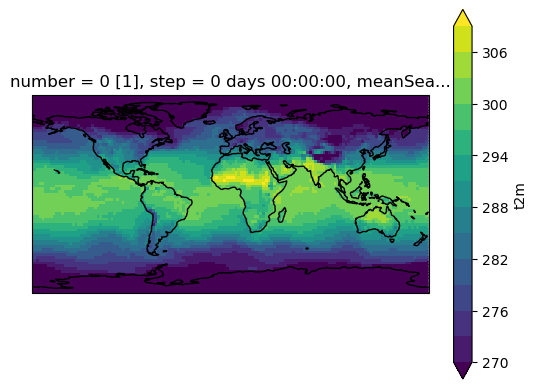

In [48]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
contour_levels = np.arange(270,312,3)
data.t2m[100].plot(ax=ax,transform=ccrs.PlateCarree(),levels= contour_levels)
ax.coastlines()

<xarray.DataArray 't2m' (latitude: 145, longitude: 288)>
[41760 values with dtype=float32]
Coordinates:
    number             int64 ...
    step               timedelta64[ns] ...
    meanSea            float64 ...
  * latitude           (latitude) float64 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * longitude          (longitude) float64 -1.25 0.0 1.25 ... 355.0 356.2 357.5
    heightAboveGround  float64 ...
    time               datetime64[ns] 2003-04-11

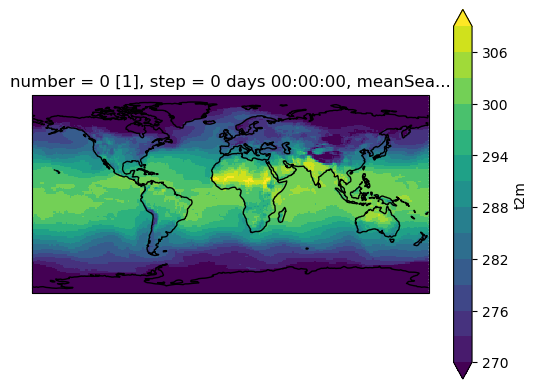

In [55]:
ax = plt.axes(projection=ccrs.PlateCarree())
t2m[100].plot(ax=ax,transform=ccrs.PlateCarree(),levels= contour_levels)
ax.coastlines()
t2m[100]

In [160]:
new_lats = np.arange(90,-91,-binsize)
new_lons = np.arange(0,360,binsize)
t2m

<xarray.DataArray 't2m' (time: 365, latitude: 145, longitude: 288)>
[15242400 values with dtype=float32]
Coordinates:
    number             int64 ...
    step               timedelta64[ns] ...
    meanSea            float64 ...
  * latitude           (latitude) float64 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * longitude          (longitude) float64 -1.25 0.0 1.25 ... 355.0 356.2 357.5
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2003-01-01 ... 2003-12-31

In [171]:
interp = RegularGridInterpolator((t2m['time'][:],t2m['latitude'][:],t2m['longitude'][:]), t2m)

In [108]:
import lib
from lib import driver
from lib import data_retrieval
from lib.dataset import varDataset
from lib.tools import get_climo
from lib.tools import get_anomaly
from lib.tools import save_ncds


In [61]:
use_vars = {
             'CPCtemp':
                {'info':('./data_clim/cpcdata','temp',
                                        {'latbounds':(20,74),
                                         'lonbounds':(190,305),

                                        'coarsegrain':2.5})}}


In [65]:
use_vars['CPCtemp']['info'][:-1],use_vars['CPCtemp']['info'][-1], 

(('./data_clim/cpcdata', 'temp'),
 {'latbounds': (20, 74), 'lonbounds': (190, 305), 'coarsegrain': 2.5})

In [106]:
# def __init__(self,varlabel,datapath,varname,**kwargs):
# varDataset(name,
           # *self.use_vars[name]['info'][:-1],# datapath
           # **self.use_vars[name]['info'][-1])# varname
# varDataset(name,
# *self.use_vars[name]['info'][:-1],
# **self.use_vars[name]['info'][-1])
out=varDataset('t2m','/data/ycheng/JRA/temp','t2m')

--> Starting to gather data
getting /data/ycheng/JRA/temp/surf_2013.nc
getting /data/ycheng/JRA/temp/surf_2014.nc
(2013, 2014)
getting climo, Line 119 dataset
--> Completed calculating climatology (1.0 seconds)
getting anomaly, Line 127 dataset
--> Completed calculating anomaly (0.4 seconds)


In [100]:
type(out)

__main__.varDataset

In [113]:
# out.save_to_netcdf('/data/ycheng/JRA/temp/output')
out.save_to_netcdf('./')

outputting t2m to netcdf, Line 545 dataset.py


In [114]:
data = xr.open_dataset('t2m.all.nc')

In [118]:
type(data)

xarray.core.dataset.Dataset

<xarray.DataArray 'lon' (lon: 288)>
array([358.75,   0.  ,   1.25, ..., 355.  , 356.25, 357.5 ])
Coordinates:
  * lon      (lon) float64 358.8 0.0 1.25 2.5 3.75 ... 353.8 355.0 356.2 357.5
Attributes:
    long_name:  longitude
    units:      degrees_east

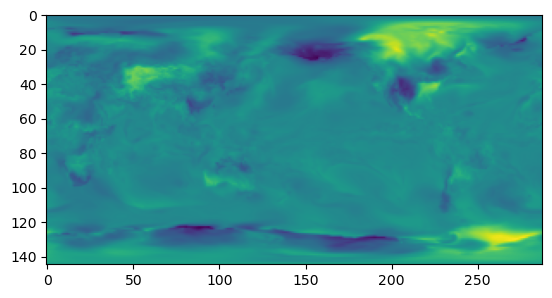

In [126]:
plt.imshow(data['anomaly'][100])
data['lon']

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

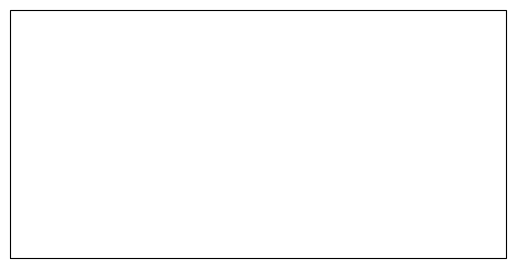

In [124]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
contour_levels = np.arange(-10,10,5)
data['anomaly'][100].plot(ax=ax,transform=ccrs.PlateCarree(),levels= contour_levels)
ax.coastlines()

In [138]:
data = data.sortby('lon')

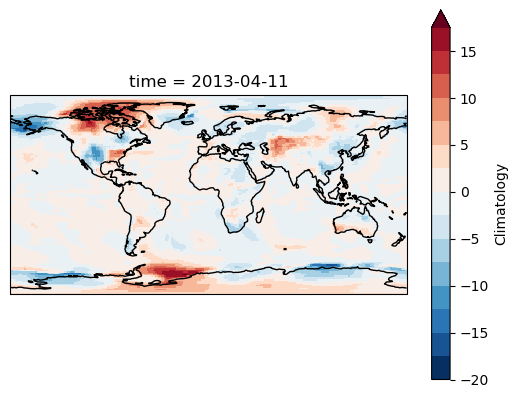

In [146]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
# contour_levels = np.arange(260,312,4)
contour_levels = np.arange(-20,20,2.5)

total = data['anomaly'][100] + data['climo'][100]
# total.plot(ax=ax,transform=ccrs.PlateCarree(),levels= contour_levels)
data['anomaly'][100].plot(ax=ax,transform=ccrs.PlateCarree(),levels= contour_levels)
ax.coastlines()